In [1]:
import numpy as np
import scipy as sp
from skimage import io
import matplotlib.pyplot as plt

BLACK = 252
WHITE = 4095
R_SCALE = 1.667969
G_SCALE = 1.000000
B_SCALE = 1.445313

gamma = 2.2

In [2]:
im = io.imread('data/campus.tiff')

# plt.imshow(im) # display image


#

In [ ]:
# Checking the image
im

array([[283, 318, 290, ..., 291, 273, 296],
       [319, 288, 331, ..., 278, 294, 279],
       [290, 329, 295, ..., 286, 274, 293],
       ...,
       [302, 284, 306, ..., 328, 459, 331],
       [274, 306, 275, ..., 466, 355, 472],
       [306, 284, 305, ..., 330, 479, 330]],
      shape=(4040, 6064), dtype=uint16)

In [ ]:
# How many bits?
np.max(im)

np.uint16(4095)

In [ ]:
# Converting to float32
im = im.astype(np.float32)

In [ ]:
# Scaling

im -= np.ones_like(im) * BLACK
im /= (WHITE - BLACK)
np.clip(im, 0, 1, out=im)

array([[0.00806661, 0.01717408, 0.00988811, ..., 0.01014832, 0.00546448,
        0.01144939],
       [0.0174343 , 0.00936768, 0.02055686, ..., 0.00676555, 0.01092896,
        0.00702576],
       [0.00988811, 0.02003643, 0.01118917, ..., 0.00884725, 0.00572469,
        0.01066875],
       ...,
       [0.01301067, 0.00832683, 0.01405152, ..., 0.01977622, 0.05386417,
        0.02055686],
       [0.00572469, 0.01405152, 0.00598491, ..., 0.05568566, 0.02680198,
        0.05724694],
       [0.01405152, 0.00832683, 0.01379131, ..., 0.02029664, 0.05906844,
        0.02029664]], shape=(4040, 6064), dtype=float32)

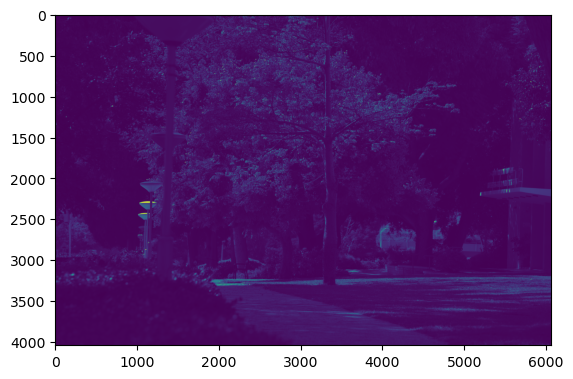

In [7]:
plt.imshow(im)

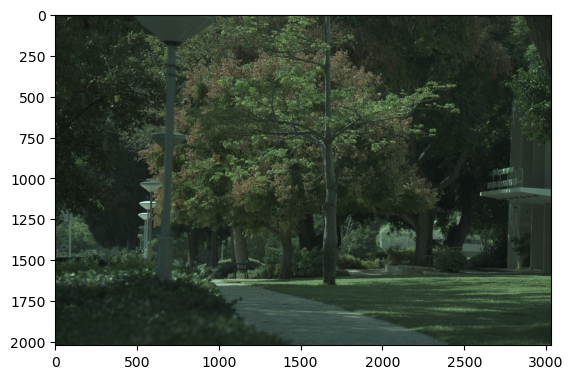

In [8]:
def to_rgb(image):
    """Convert a Bayer image to RGB image
    Input:
        im: H x W array"""
    im1 = image[0::2, 0::2]
    im2 = image[0::2, 1::2]
    im3 = image[1::2, 0::2]
    im4 = image[1::2, 1::2]
    im_rgb = np.dstack((im1, im3, im4))
    return im_rgb

plt.imshow(to_rgb(im)** (1/gamma))

## White Balance

In [9]:
def white_world_assumption(image):
    """White world assumption
    Input:
        image: H x W x 3 array"""
    image = image.copy()
    im1 = image[0::2, 0::2]
    im2 = image[0::2, 1::2]
    im3 = image[1::2, 0::2]
    im4 = image[1::2, 1::2]
    r_max = np.max(im1) # Red=im1
    g_max = np.max([np.max(im2),np.max(im3)]) # Green=im2,im3
    b_max = np.max(im4) # Blue=im4
    im_red_normalized = im1 * g_max / r_max
    im_blue_normalized = im4 * g_max / b_max
    image[0::2, 0::2] = im_red_normalized
    image[1::2, 1::2] = im_blue_normalized
    return image
    
def scale_channels(image):
    """Scale channels according to given scales
    Input:
        image: H x W x 3 array"""
    image = image.copy()
    image[0::2, 0::2] *= R_SCALE
    image[0::2, 1::2] *= G_SCALE
    image[1::2, 0::2] *= G_SCALE
    image[1::2, 1::2] *= B_SCALE
    return image

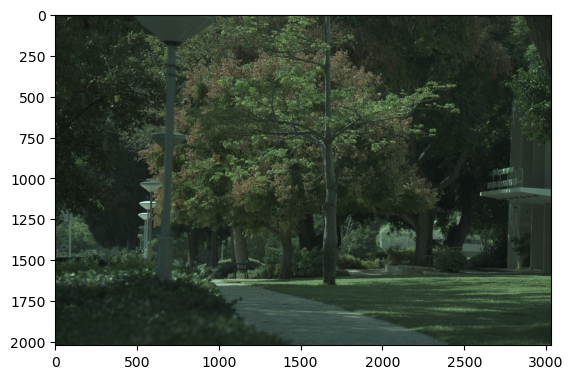

In [10]:
plt.imshow(to_rgb(white_world_assumption(im)) ** (1/gamma))

In [ ]:
# Scaling channels with given scales from camera
im = scale_channels(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2618116].


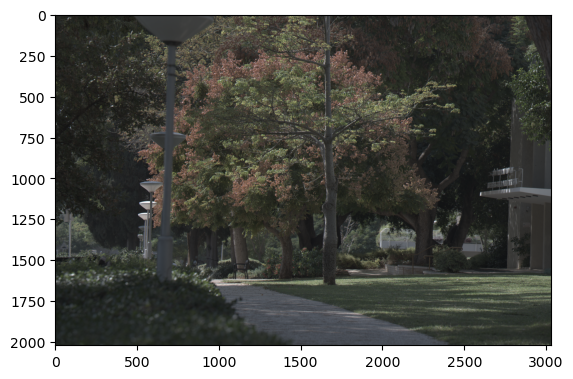

In [12]:
plt.imshow(to_rgb(im) ** (1/gamma))

## Interpolation

In [13]:
# len(im[0,:]), len(im[:,0])
im_red = im[0::2, 0::2]
im_blue = im[1::2, 1::2]
im_green1 = im[0::2, 1::2]
im_green2 = im[1::2, 0::2]

In [15]:
x = np.arange(0, im.shape[1],2)
y = np.arange(0, im.shape[0],2)

X_full, Y_full = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))

In [16]:
# interpolate each component
interp = sp.interpolate.RegularGridInterpolator((y, x), im_red, fill_value=None, bounds_error=False)
red_full_image = interp((Y_full, X_full))
print('Red done')

interp = sp.interpolate.RegularGridInterpolator((y + 1, x + 1), im_blue, fill_value=None, bounds_error=False)
blue_full_image = interp((Y_full, X_full))
print('Blue done')

interp = sp.interpolate.RegularGridInterpolator((y, x + 1), im_green1, fill_value=None, bounds_error=False)
green1_full_image = interp((Y_full, X_full))
print('Green1 done')

interp = sp.interpolate.RegularGridInterpolator((y + 1, x), im_green2, fill_value=None, bounds_error=False)
green2_full_image = interp((Y_full, X_full))

Red done
Blue done
Green1 done


In [ ]:
green_full_image = 0.5 * (green1_full_image + green2_full_image)
full_image = np.dstack((red_full_image, green_full_image, blue_full_image))
np.clip(full_image, 0, 1, out=full_image);

array([[[0.01345486, 0.01691387, 0.01391532],
        [0.01497396, 0.01814988, 0.01372728],
        [0.01649306, 0.0193859 , 0.01353923],
        ...,
        [0.00911458, 0.01018085, 0.01034247],
        [0.00911458, 0.01118917, 0.01024845],
        [0.00911458, 0.0121975 , 0.01015442]],

       [[0.01497396, 0.01753188, 0.01335119],
        [0.01627604, 0.01880042, 0.01353923],
        [0.01757813, 0.02006896, 0.01372728],
        ...,
        [0.0093316 , 0.00969295, 0.00977833],
        [0.0093316 , 0.01060369, 0.00996638],
        [0.0093316 , 0.01151444, 0.01015442]],

       [[0.01649306, 0.01814988, 0.01278705],
        [0.01757813, 0.01945095, 0.01335119],
        [0.0186632 , 0.02075202, 0.01391532],
        ...,
        [0.00954861, 0.00920505, 0.0092142 ],
        [0.00954861, 0.01001821, 0.00968431],
        [0.00954861, 0.01083138, 0.01015442]],

       ...,

       [[0.01019965, 0.0136612 , 0.01241096],
        [0.01019965, 0.01379131, 0.01203487],
        [0.01019965, 0

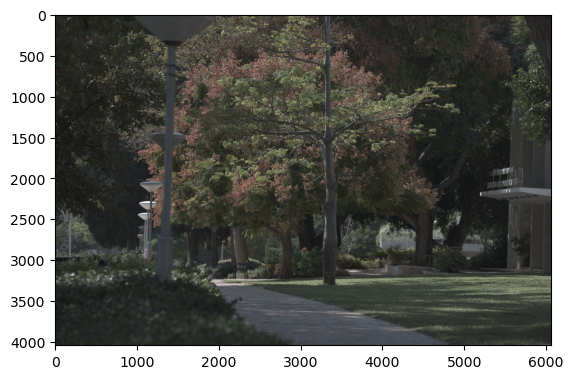

In [18]:
plt.imshow(full_image ** (1/gamma))

## Brighting Up the Image

In [ ]:
p = 99
value_to_scale = np.percentile(full_image, p)
bright_full_image = full_image.copy()
bright_full_image /= value_to_scale
bright_full_image = np.clip(bright_full_image, 0, 1)

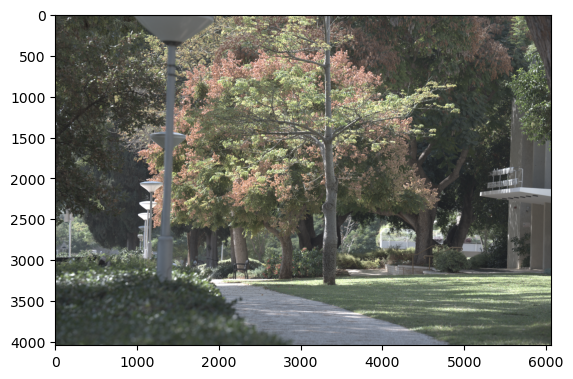

In [20]:
plt.imshow(bright_full_image ** (1/gamma))

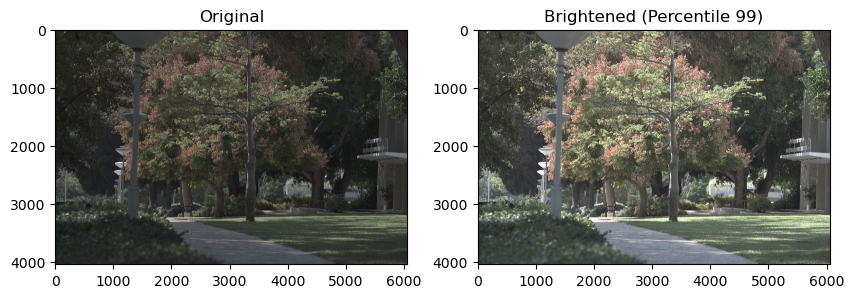

In [56]:
fig = plt.figure()
fig.set_size_inches(10,5)
fig.add_subplot(1, 2, 1) 
plt.imshow(full_image ** (1/gamma))
plt.title('Original')
fig.add_subplot(1, 2, 2)
plt.imshow(bright_full_image ** (1/gamma))
plt.title(f'Brightened (Percentile {p})')
plt.savefig('brightness_comparison.png')
plt.show()

## Saving the image - png and jpeg

In [45]:
full_image_to_save = (bright_full_image ** (1/gamma)) * 255
full_image_to_save = full_image_to_save.astype(np.uint8)

In [46]:
io.imsave('campus.png', full_image_to_save)


In [47]:
io.imsave('campus.jpeg', full_image_to_save, quality=95)

C:\Users\Chaya\AppData\Local\Temp\ipykernel_16144\4144012674.py:1: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imsave`.
  io.imsave('campus.jpeg', full_image_to_save, quality=95)


## Make color go pop

In [48]:
poppy_factor = 1.2

In [49]:
from skimage.color import rgb2hsv, hsv2rgb


In [50]:
full_image_to_save_hsv = rgb2hsv(full_image_to_save)
full_image_to_save_hsv[..., 1] *= poppy_factor
full_image_poppy_rgb = hsv2rgb(full_image_to_save_hsv)
np.clip(full_image_poppy_rgb, 0, 1, out=full_image_poppy_rgb);

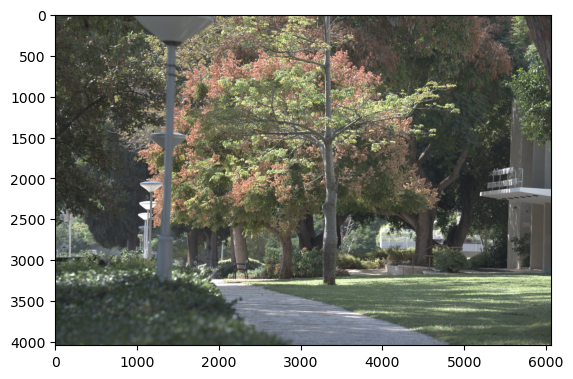

In [51]:
plt.imshow(full_image_poppy_rgb)

In [53]:
pop_image_to_save = (full_image_poppy_rgb) * 255
pop_image_to_save = pop_image_to_save.astype(np.uint8)
io.imsave('campus_poppy.png', pop_image_to_save)
io.imsave('campus_poppy.jpeg', pop_image_to_save, quality=95)


C:\Users\Chaya\AppData\Local\Temp\ipykernel_16144\581434593.py:4: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imsave`.
  io.imsave('campus_poppy.jpeg', pop_image_to_save, quality=95)
